# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

/home/kolya/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/kolya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [4]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating test split: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7600/7600 [00:00<00:00, 985034.78 examples/s]


Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [5]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:09<00:00, 12546.48it/s]

Размер словаря: 11842


In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [22]:
class WordDataset(Dataset):
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [33]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [34]:
batch = next(iter(train_dataloader))

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [36]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [127]:
class RNNmodel(nn.Module):
    def __init__(self, words_size, hidden_dim = 512, agg_type = 'max', rnn_num_layers = 2, 
                 linear_num = 2, dropout_rate = 0.2, non_lin_func = 'relu', class_num = 4):

        super().__init__()
        
        self.emb = nn.Embedding(words_size, hidden_dim)

        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers = rnn_num_layers, batch_first = True)
        
        agg_types = {'mean', 'max', 'min', 'last'}
        
        if agg_type in agg_types:
            self.agg_type = agg_type
        else:
            raise ValueError(f'agg_type should be one of {agg_types}')
            
        self.linear_layers = []
        dim = hidden_dim
        for i in range(linear_num):
            self.linear_layers.append(nn.Linear(dim, dim//2).to(device))
            dim = dim//2

        functions = {'relu', 'tanh', 'sigmoid'}

        if non_lin_func in functions:
            if non_lin_func == 'relu':
                self.non_lin = nn.ReLU()
            if non_lin_func == 'tanh':
                self.non_lin = nn.Tanh()
            if non_lin_func == 'sigmoid':
                self.non_lin = nn.Sigmoid()
        else:
            raise ValueError(f'Nonlinear func should be one of: {functions}')

        
        self.dropout = nn.Dropout(dropout_rate)

        self.projection = nn.Linear(self.linear_layers[-1].out_features, class_num)


    def forward(self, input_batch):
        x = self.emb(input_batch)
        x, _ = self.rnn(x)

        if self.agg_type == 'mean':
            x = x.mean(dim = 1)
        if self.agg_type == 'max':
            x = x.max(dim = 1)[0]
        if self.agg_type == 'min':
            x = x.min(dim = 1)[0]
        if self.agg_type == 'last':
            x = x[:, -1, :]

        for i in range(len(self.linear_layers)):
            x = self.dropout(self.linear_layers[i](self.non_lin(x)))

        x = self.non_lin(x)

        return self.projection(x)
        
    

In [202]:
model = RNNmodel(len(vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [203]:
epoch_num = 5

hist = {}

hist['train'] = []
hist['test'] = {}
hist['test']['loss'] = []
hist['test']['acc'] = []

for epoch in range(epoch_num):

    model.train()
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        #batch, labels = batch.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(batch['input_ids'])
        labels = batch['label']
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    hist['train'].append(sum(epoch_losses) / len(epoch_losses))

    model.eval()


    epoch_losses = []
    for batch in eval_dataloader:
        output = model(batch['input_ids'])
        labels = batch['label']
        loss = criterion(output, labels)
        epoch_losses.append(loss.item())

    hist['test']['loss'].append(sum(epoch_losses) / len(epoch_losses))

    
    hist['test']['acc'].append(evaluate(model, eval_dataloader))
    print(f'Эпоха {epoch}, качество на тесте: {hist['test']['acc'][-1]:.2f}')
    



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:43<00:00, 86.71it/s]


Эпоха 0, качество на тесте: 0.35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:41<00:00, 89.85it/s]


Эпоха 1, качество на тесте: 0.43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:47<00:00, 78.70it/s]


Эпоха 2, качество на тесте: 0.48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 69.33it/s]


Эпоха 3, качество на тесте: 0.49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:48<00:00, 78.12it/s]


Эпоха 4, качество на тесте: 0.66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 96.57it/s]


Эпоха 5, качество на тесте: 0.67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:40<00:00, 93.11it/s]


Эпоха 6, качество на тесте: 0.67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 97.27it/s]


Эпоха 7, качество на тесте: 0.67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 96.65it/s]


Эпоха 8, качество на тесте: 0.68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:39<00:00, 95.18it/s]


Эпоха 9, качество на тесте: 0.69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 96.20it/s]


Эпоха 10, качество на тесте: 0.69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 96.27it/s]


Эпоха 11, качество на тесте: 0.69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:40<00:00, 91.53it/s]


Эпоха 12, качество на тесте: 0.69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:39<00:00, 95.29it/s]


Эпоха 13, качество на тесте: 0.69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:39<00:00, 94.75it/s]


Эпоха 14, качество на тесте: 0.71


In [199]:
hist

{'train': [1.1581743035157521,
  0.7174257876078288,
  0.7583731164137523,
  0.5720642964839935,
  0.4657746363123258],
 'test': {'loss': [0.85169578889373,
   0.6212553759669043,
   0.6602861148536585,
   0.4849793523739857,
   0.41138837396339245],
  'acc': [0.5069999694824219,
   0.7324000000953674,
   0.7698000073432922,
   0.8447999954223633,
   0.8687999844551086]}}

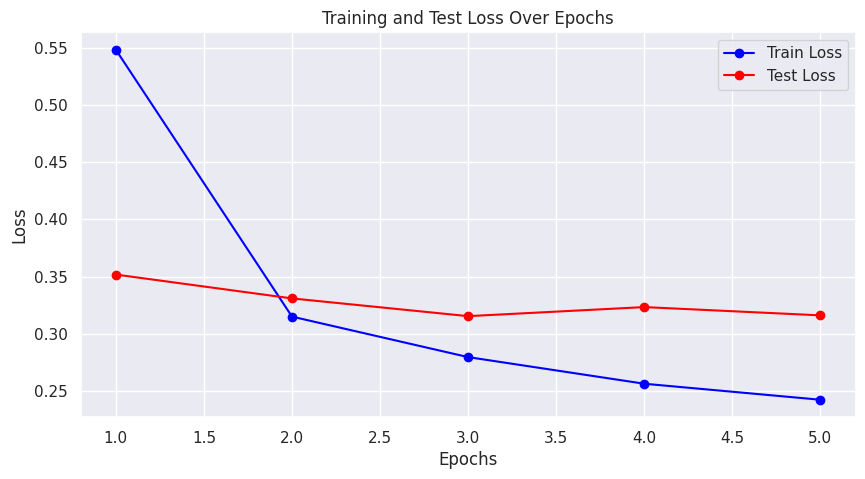

In [215]:
import matplotlib.pyplot as plt


# Количество эпох
epochs = range(1, len(hist['mean']['train']) + 1)

# Создаем график
plt.figure(figsize=(10, 5))

train = hist['mean']['train']
test = hist['mean']['test']['loss']

plt.plot(epochs, train, 'bo-', label='Train Loss')  # 'bo-' - синие точки и линии
plt.plot(epochs, test, 'ro-', label='Test Loss')  # 'ro-' - красные точки и линии

# Добавляем подписи и заголовок
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()

# Показываем график
plt.show()

In [209]:
evaluate(model, eval_dataloader)

0.241799995303154

In [216]:
epoch_num = 5

hist = {}



for param in [1, 2, 3]:
    
    model = RNNmodel(len(vocab), agg_type='max', rnn_num_layers=param).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index = word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    
    hist[param] = {}
    hist[param]['train'] = []
    hist[param]['test'] = {}
    hist[param]['test']['loss'] = []
    hist[param]['test']['acc'] = []
    
    
    for epoch in range(epoch_num):
    
        model.train()
        epoch_losses = []
        for batch in tqdm(train_dataloader):
            #batch, labels = batch.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(batch['input_ids'])
            labels = batch['label']
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        
        hist[param]['train'].append(sum(epoch_losses) / len(epoch_losses))
    
        model.eval()
    
    
        epoch_losses = []
        for batch in eval_dataloader:
            output = model(batch['input_ids'])
            labels = batch['label']
            loss = criterion(output, labels)
            epoch_losses.append(loss.item())
    
        hist[param]['test']['loss'].append(sum(epoch_losses) / len(epoch_losses))
    
        
        hist[param]['test']['acc'].append(evaluate(model, eval_dataloader))
        print(f'Эпоха {epoch}, качество на тесте: {hist[param]['test']['acc'][-1]:.2f}, {param=}')
        



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:39<00:00, 95.51it/s]


Эпоха 0, качество на тесте: 0.88, param=1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 97.56it/s]


Эпоха 1, качество на тесте: 0.91, param=1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 97.31it/s]


Эпоха 2, качество на тесте: 0.91, param=1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 98.33it/s]


Эпоха 3, качество на тесте: 0.91, param=1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:35<00:00, 104.71it/s]


Эпоха 4, качество на тесте: 0.90, param=1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:39<00:00, 94.65it/s]


Эпоха 0, качество на тесте: 0.65, param=2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:39<00:00, 95.38it/s]


Эпоха 1, качество на тесте: 0.66, param=2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:39<00:00, 95.41it/s]


Эпоха 2, качество на тесте: 0.79, param=2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:39<00:00, 94.09it/s]


Эпоха 3, качество на тесте: 0.81, param=2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:39<00:00, 95.29it/s]


Эпоха 4, качество на тесте: 0.82, param=2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:43<00:00, 86.47it/s]


Эпоха 0, качество на тесте: 0.24, param=3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:43<00:00, 87.14it/s]


Эпоха 1, качество на тесте: 0.26, param=3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:43<00:00, 85.24it/s]


Эпоха 2, качество на тесте: 0.25, param=3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:43<00:00, 86.11it/s]


Эпоха 3, качество на тесте: 0.24, param=3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:46<00:00, 80.87it/s]


Эпоха 4, качество на тесте: 0.26, param=3


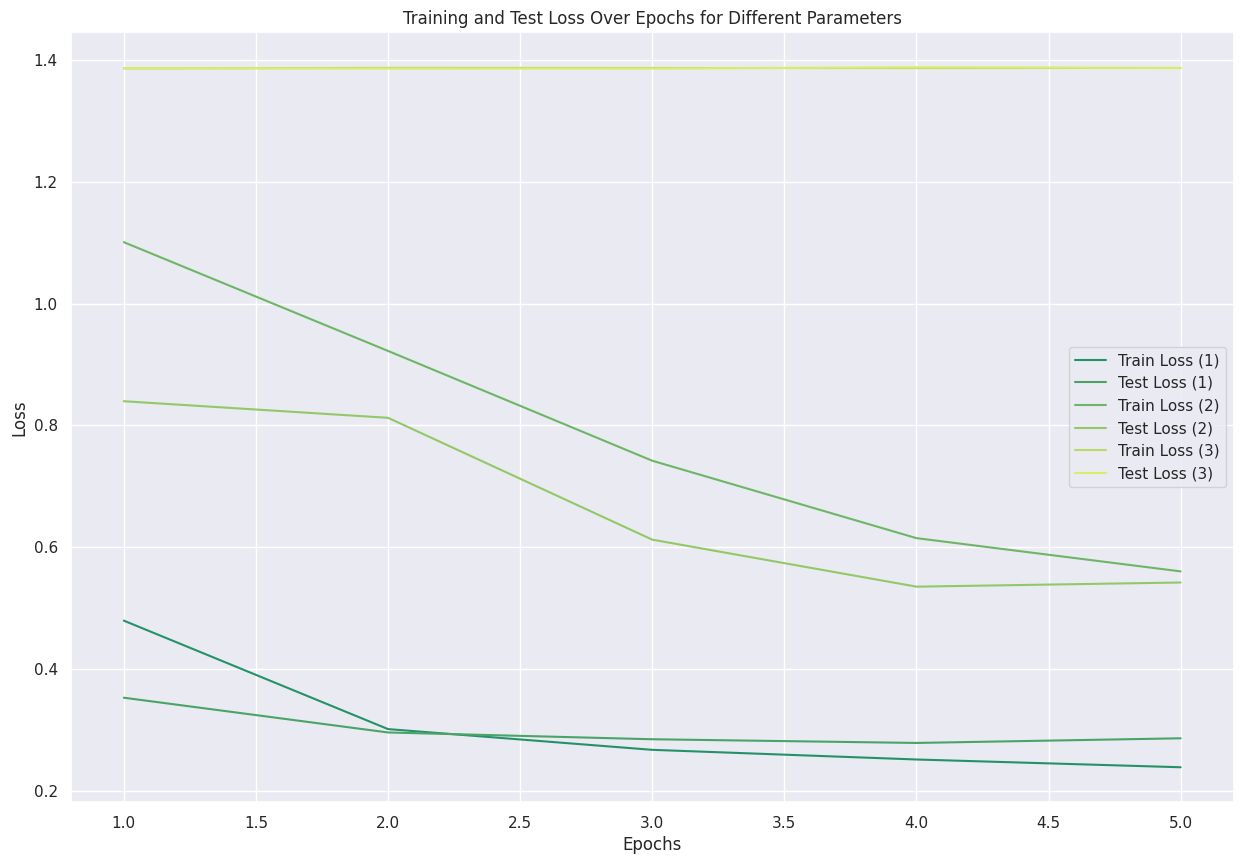

In [217]:
# Создаем график
plt.figure(figsize=(15, 10))

# Перебираем каждый параметр в словаре hist
for param in hist.keys():
    epochs = range(1, len(hist[param]['train']) + 1)
    plt.plot(epochs, hist[param]['train'], label=f'Train Loss ({param})')
    plt.plot(epochs, hist[param]['test']['loss'], label=f'Test Loss ({param})')

# Добавляем подписи и заголовок
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs for Different Parameters')
plt.legend()

# Показываем график
plt.show()

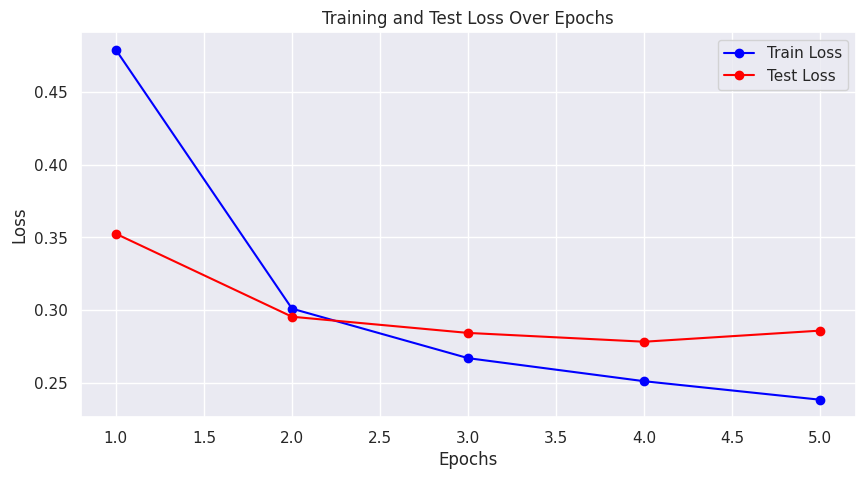

In [219]:
import matplotlib.pyplot as plt


# Количество эпох
epochs = range(1, 6)

# Создаем график
plt.figure(figsize=(10, 5))

train = hist[1]['train']
test = hist[1]['test']['loss']

plt.plot(epochs, train, 'bo-', label='Train Loss')  # 'bo-' - синие точки и линии
plt.plot(epochs, test, 'ro-', label='Test Loss')  # 'ro-' - красные точки и линии

# Добавляем подписи и заголовок
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()

# Показываем график
plt.show()

In [221]:
epoch_num = 5

hist = {}



for param in ['sigmoid']:
    
    model = RNNmodel(len(vocab), agg_type='max', rnn_num_layers=1, non_lin_func=param).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index = word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    
    hist[param] = {}
    hist[param]['train'] = []
    hist[param]['test'] = {}
    hist[param]['test']['loss'] = []
    hist[param]['test']['acc'] = []
    
    
    for epoch in range(epoch_num):
    
        model.train()
        epoch_losses = []
        for batch in tqdm(train_dataloader):
            #batch, labels = batch.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(batch['input_ids'])
            labels = batch['label']
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        
        hist[param]['train'].append(sum(epoch_losses) / len(epoch_losses))
    
        model.eval()
    
    
        epoch_losses = []
        for batch in eval_dataloader:
            output = model(batch['input_ids'])
            labels = batch['label']
            loss = criterion(output, labels)
            epoch_losses.append(loss.item())
    
        hist[param]['test']['loss'].append(sum(epoch_losses) / len(epoch_losses))
    
        
        hist[param]['test']['acc'].append(evaluate(model, eval_dataloader))
        print(f'Эпоха {epoch}, качество на тесте: {hist[param]['test']['acc'][-1]:.2f}, {param=}')
        



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 102.74it/s]


Эпоха 0, качество на тесте: 0.51, param='sigmoid'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:35<00:00, 105.23it/s]


Эпоха 1, качество на тесте: 0.68, param='sigmoid'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 96.82it/s]


Эпоха 2, качество на тесте: 0.68, param='sigmoid'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:39<00:00, 95.88it/s]


Эпоха 3, качество на тесте: 0.69, param='sigmoid'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:35<00:00, 104.27it/s]


Эпоха 4, качество на тесте: 0.70, param='sigmoid'


In [224]:
epoch_num = 4

hist = {}



for param in [0.1,0.25, 0.5]:
    
    model = RNNmodel(len(vocab), agg_type='max', rnn_num_layers=1, non_lin_func='tanh', linear_num=2, dropout_rate=param).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index = word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    
    hist[param] = {}
    hist[param]['train'] = []
    hist[param]['test'] = {}
    hist[param]['test']['loss'] = []
    hist[param]['test']['acc'] = []
    
    
    for epoch in range(epoch_num):
    
        model.train()
        epoch_losses = []
        for batch in tqdm(train_dataloader):
            #batch, labels = batch.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(batch['input_ids'])
            labels = batch['label']
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        
        hist[param]['train'].append(sum(epoch_losses) / len(epoch_losses))
    
        model.eval()
    
    
        epoch_losses = []
        for batch in eval_dataloader:
            output = model(batch['input_ids'])
            labels = batch['label']
            loss = criterion(output, labels)
            epoch_losses.append(loss.item())
    
        hist[param]['test']['loss'].append(sum(epoch_losses) / len(epoch_losses))
    
        
        hist[param]['test']['acc'].append(evaluate(model, eval_dataloader))
        print(f'Эпоха {epoch}, качество на тесте: {hist[param]['test']['acc'][-1]:.4f}, {param=}')
        



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:37<00:00, 99.19it/s]


Эпоха 0, качество на тесте: 0.9040, param=0.1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 103.49it/s]


Эпоха 1, качество на тесте: 0.9114, param=0.1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 98.60it/s]


Эпоха 2, качество на тесте: 0.9126, param=0.1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 102.31it/s]


Эпоха 3, качество на тесте: 0.9142, param=0.1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 102.51it/s]


Эпоха 0, качество на тесте: 0.8754, param=0.25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:35<00:00, 104.43it/s]


Эпоха 1, качество на тесте: 0.9076, param=0.25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 98.32it/s]


Эпоха 2, качество на тесте: 0.9126, param=0.25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 103.11it/s]


Эпоха 3, качество на тесте: 0.9162, param=0.25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 103.64it/s]


Эпоха 0, качество на тесте: 0.8978, param=0.5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 102.45it/s]


Эпоха 1, качество на тесте: 0.9074, param=0.5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:37<00:00, 100.89it/s]


Эпоха 2, качество на тесте: 0.9098, param=0.5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 102.49it/s]


Эпоха 3, качество на тесте: 0.9140, param=0.5


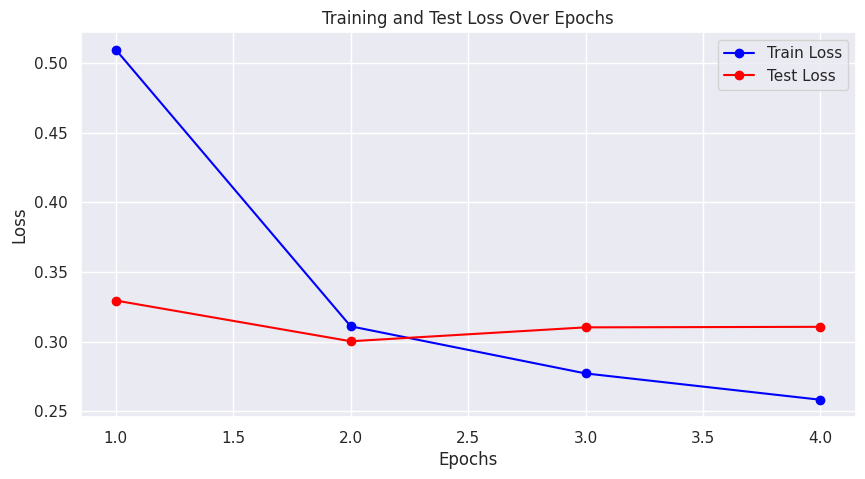

In [231]:
import matplotlib.pyplot as plt


# Количество эпох
epochs = range(1, epoch_num+1)

# Создаем график
plt.figure(figsize=(10, 5))

train = hist[0.5]['train']
test = hist[0.5]['test']['loss']

plt.plot(epochs, train, 'bo-', label='Train Loss')  # 'bo-' - синие точки и линии
plt.plot(epochs, test, 'ro-', label='Test Loss')  # 'ro-' - красные точки и линии

# Добавляем подписи и заголовок
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()

# Показываем график
plt.show()

In [232]:
epoch_num = 10

hist = {}



for param in [128, 256, 512, 1024]:
    
    model = RNNmodel(len(vocab), agg_type='max', rnn_num_layers=1, non_lin_func='tanh', 
                     linear_num=2, dropout_rate=0.25, hidden_dim = param).to(device)
    
    criterion = nn.CrossEntropyLoss(ignore_index = word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    
    hist[param] = {}
    hist[param]['train'] = []
    hist[param]['test'] = {}
    hist[param]['test']['loss'] = []
    hist[param]['test']['acc'] = []
    
    
    for epoch in range(epoch_num):
    
        model.train()
        epoch_losses = []
        for batch in tqdm(train_dataloader):
            #batch, labels = batch.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(batch['input_ids'])
            labels = batch['label']
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        
        hist[param]['train'].append(sum(epoch_losses) / len(epoch_losses))
    
        model.eval()
    
    
        epoch_losses = []
        for batch in eval_dataloader:
            output = model(batch['input_ids'])
            labels = batch['label']
            loss = criterion(output, labels)
            epoch_losses.append(loss.item())
    
        hist[param]['test']['loss'].append(sum(epoch_losses) / len(epoch_losses))
    
        
        hist[param]['test']['acc'].append(evaluate(model, eval_dataloader))
        print(f'Эпоха {epoch}, качество на тесте: {hist[param]['test']['acc'][-1]:.4f}, {param=}')
        


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:26<00:00, 141.92it/s]


Эпоха 0, качество на тесте: 0.8908, param=128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:25<00:00, 144.73it/s]


Эпоха 1, качество на тесте: 0.9064, param=128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:26<00:00, 144.21it/s]


Эпоха 2, качество на тесте: 0.9076, param=128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:25<00:00, 147.32it/s]


Эпоха 3, качество на тесте: 0.9108, param=128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:26<00:00, 142.78it/s]


Эпоха 4, качество на тесте: 0.9066, param=128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:27<00:00, 138.02it/s]


Эпоха 5, качество на тесте: 0.9118, param=128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:25<00:00, 144.93it/s]


Эпоха 6, качество на тесте: 0.9128, param=128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:25<00:00, 144.85it/s]


Эпоха 7, качество на тесте: 0.9138, param=128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:25<00:00, 145.21it/s]


Эпоха 8, качество на тесте: 0.9130, param=128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:25<00:00, 149.56it/s]


Эпоха 9, качество на тесте: 0.9146, param=128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:28<00:00, 131.41it/s]


Эпоха 0, качество на тесте: 0.8984, param=256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:27<00:00, 136.70it/s]


Эпоха 1, качество на тесте: 0.9032, param=256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:27<00:00, 137.01it/s]


Эпоха 2, качество на тесте: 0.9068, param=256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:26<00:00, 140.73it/s]


Эпоха 3, качество на тесте: 0.9066, param=256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:28<00:00, 132.08it/s]


Эпоха 4, качество на тесте: 0.9090, param=256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:26<00:00, 139.06it/s]


Эпоха 5, качество на тесте: 0.9112, param=256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:27<00:00, 136.60it/s]


Эпоха 6, качество на тесте: 0.9080, param=256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:28<00:00, 133.14it/s]


Эпоха 7, качество на тесте: 0.9124, param=256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:26<00:00, 140.99it/s]


Эпоха 8, качество на тесте: 0.9094, param=256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:27<00:00, 136.40it/s]


Эпоха 9, качество на тесте: 0.9132, param=256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 103.12it/s]


Эпоха 0, качество на тесте: 0.8914, param=512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 101.97it/s]


Эпоха 1, качество на тесте: 0.9148, param=512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 102.98it/s]


Эпоха 2, качество на тесте: 0.9086, param=512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 101.80it/s]


Эпоха 3, качество на тесте: 0.9060, param=512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 103.95it/s]


Эпоха 4, качество на тесте: 0.9126, param=512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 101.61it/s]


Эпоха 5, качество на тесте: 0.8968, param=512


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:37<00:00, 98.79it/s]


Эпоха 6, качество на тесте: 0.9100, param=512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:35<00:00, 105.64it/s]


Эпоха 7, качество на тесте: 0.9070, param=512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:34<00:00, 107.21it/s]


Эпоха 8, качество на тесте: 0.9102, param=512


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 103.70it/s]


Эпоха 9, качество на тесте: 0.9090, param=512


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 68.97it/s]


Эпоха 0, качество на тесте: 0.8852, param=1024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 68.49it/s]


Эпоха 1, качество на тесте: 0.9014, param=1024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 68.78it/s]


Эпоха 2, качество на тесте: 0.9084, param=1024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 68.76it/s]


Эпоха 3, качество на тесте: 0.9086, param=1024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 68.77it/s]


Эпоха 4, качество на тесте: 0.9130, param=1024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 68.77it/s]


Эпоха 5, качество на тесте: 0.9130, param=1024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 68.74it/s]


Эпоха 6, качество на тесте: 0.9068, param=1024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 68.69it/s]


Эпоха 7, качество на тесте: 0.9108, param=1024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 68.88it/s]


Эпоха 8, качество на тесте: 0.9084, param=1024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:54<00:00, 68.86it/s]


Эпоха 9, качество на тесте: 0.9080, param=1024
